In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
from scipy.optimize import fsolve
sns.set();
import tqdm 

The general formulation of Lambda-Omega systems is:

$\frac{dx}{dt} = \Lambda(r)x - \Omega(r)y$

$\frac{dy}{dt} = \Omega(r)x + \Lambda(r)y$

with $r^2 = x^2 + y^2$

which upon cartesian to polar coordinates change is converted to:

$x = r\cos(\theta)$

$y = r\sin(\theta)$

$\frac{dr}{dt} = r\Lambda(r)$

$\frac{d\theta}{dt} = \Omega(r)$

Under this formulation, $\Lambda(\vec r) = 0$ are the circular limit cycles.

## Calculation of the nullclines

The nullclines of the system are the values for $\frac{dx}{dt} = 0$ and $\frac{dy}{dt} = 0$

which for the system above are:

$ay^3 + bxy^2 + (\omega + ax^2)y - (\lambda - bx^2)x = 0$ (x-nullcline)

$ax^3 − bx^2y + (\omega + ay^2)x + (\lambda − by^2)y = 0$ (y-nullcline)

## Solution

In [2]:
class LambdaOmega:
    """
    Solves the system integrating the polar coordinates
    """    
    def __init__(self, l, o, a, b):
        self.l = l
        self.o = o
        self.a = a
        self.b = b
        
    def lambda_function(self, r):
        return self.l - self.b*r*r

    def omega_function(self, r):
        return self.o + self.a*r*r
    
    def df_dt(self, t, f0):
        r = f0[0]
        theta = f0[1]
    
        #dr/dt
        dr_dt = r*self.lambda_function(r)
    
        #dtheta/dt
        dtheta_dt = self.omega_function(r)
    
        return [dr_dt, dtheta_dt]
    
    def ode_solve(self, r_0, theta_0, tini, tfin, nsteps):

        #times to integrate
        ts = np.linspace(tini, tfin, nsteps)

        #initial conditions
        self.r_0 = r_0
        self.theta_0 = theta_0
        f0 = [r_0, theta_0]

        #Solve
        sol = solve_ivp(self.df_dt, t_span = [tini, tfin], t_eval = ts, y0 = f0)
        
        r_t = sol.y[0]
        theta_t = sol.y[1]
        
        self.t = sol.t
        self.x_t = r_t*np.cos(theta_t) 
        self.y_t = r_t*np.sin(theta_t)
        self.dx_dt = self.lambda_function(r_t)*self.x_t - self.omega_function(r_t)*self.y_t
        self.dy_dt = self.omega_function(r_t)*self.x_t + self.lambda_function(r_t)*self.y_t
        
        return [self.t, self.dx_dt, self.dy_dt, self.x_t, self.y_t]
        
    def nullclines(self, extend = 2, npoints = 100):
        
        def x_nullcline(y):
            return self.a*y**3 + self.b*x_vals*y**2 + (self.o + self.a*x_vals**2)*y - (self.l - self.b*x_vals**2)*x_vals

        def y_nullcline(x):
            return self.a*x**3 - self.b*x**2*y_vals + (self.o + self.a*y_vals**2)*x + (self.l - self.b*y_vals**2)*y_vals

        self.x_null = []
        self.y_null = []
        self.vals = np.linspace(-extend,extend, npoints)
        for i in self.vals:
            x_vals = i
            y_vals = i
            self.x_null.append(fsolve(x_nullcline,0))
            self.y_null.append(fsolve(y_nullcline,0))
            
        return [self.vals, self.x_null, self.y_null]    

In [3]:
class LambdaOmega2:
    """
    Solves the system integrating the cartesian coordinates and add a term to include white noise
    """
    def __init__(self, l, o, a, b, D = 0):
        self.l = l
        self.o = o
        self.a = a
        self.b = b
        self.D = D
        
    def lambda_function(self, r):
        return self.l - self.b*r*r

    def omega_function(self, r):
        return self.o + self.a*r*r
    
    def noise(self, D = 0):
        return D*np.random.uniform(-1,1)
    
    def df_dt(self, t, f0):
        X0 = f0[0]
        Y0 = f0[1]
    
        r = np.sqrt(X0**2 + Y0**2)
        
        #dX/dt
        dX_dt = self.lambda_function(r)*X0 - self.omega_function(r)*Y0 + self.noise(self.D)
    
        #dY/dt
        dY_dt = self.omega_function(r)*X0 + self.lambda_function(r)*Y0
    
        return [dX_dt, dY_dt]
    
    def ode_solve(self, X_0, Y_0, tini, tfin, timestep):

        #times to integrate
        nstep = int((tfin - tini)/timestep)
        ts = np.linspace(tini, tfin, nstep, endpoint = True)

        #initial conditions
        self.X_0 = X_0
        self.Y_0 = Y_0
        f0 = [X_0, Y_0]

        #Solve
        sol = solve_ivp(self.df_dt, t_span = [tini, tfin], t_eval = ts, y0 = f0, method='RK45')

        self.t = sol.t

        self.x_t = sol.y[0]
        self.y_t = sol.y[1]
        r_t = np.sqrt(self.x_t**2 + self.y_t**2)
        self.dx_dt = self.lambda_function(r_t)*self.x_t - self.omega_function(r_t)*self.y_t
        self.dy_dt = self.omega_function(r_t)*self.x_t + self.lambda_function(r_t)*self.y_t
        
        return [self.t, self.dx_dt, self.dy_dt, self.x_t, self.y_t]
        
    def nullclines(self, extend = 2, npoints = 100):
        
        def x_nullcline(y):
            return self.a*y**3 + self.b*x_vals*y**2 + (self.o + self.a*x_vals**2)*y - (self.l - self.b*x_vals**2)*x_vals

        def y_nullcline(x):
            return self.a*x**3 - self.b*x**2*y_vals + (self.o + self.a*y_vals**2)*x + (self.l - self.b*y_vals**2)*y_vals

        self.x_null = []
        self.y_null = []
        self.vals = np.linspace(-extend,extend, npoints)
        for i in self.vals:
            x_vals = i
            y_vals = i
            self.x_null.append(fsolve(x_nullcline,0))
            self.y_null.append(fsolve(y_nullcline,0))
            
        return [self.vals, self.x_null, self.y_null] 

## Analysis of changing simultaneously $\lambda$ and b 

Using the new class to resolve the ODEs in the cartesian coordinates, it is easy to add noise to the x(t) coordinate

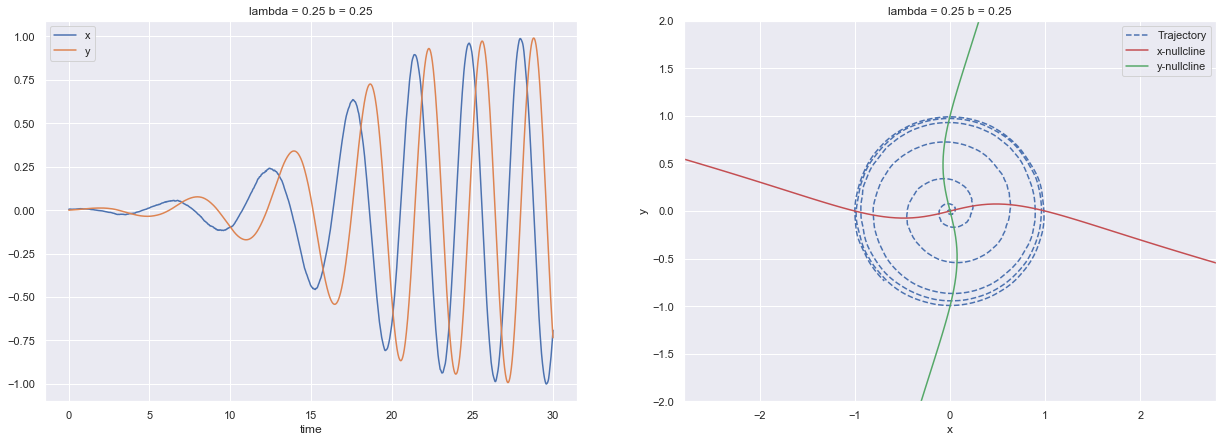

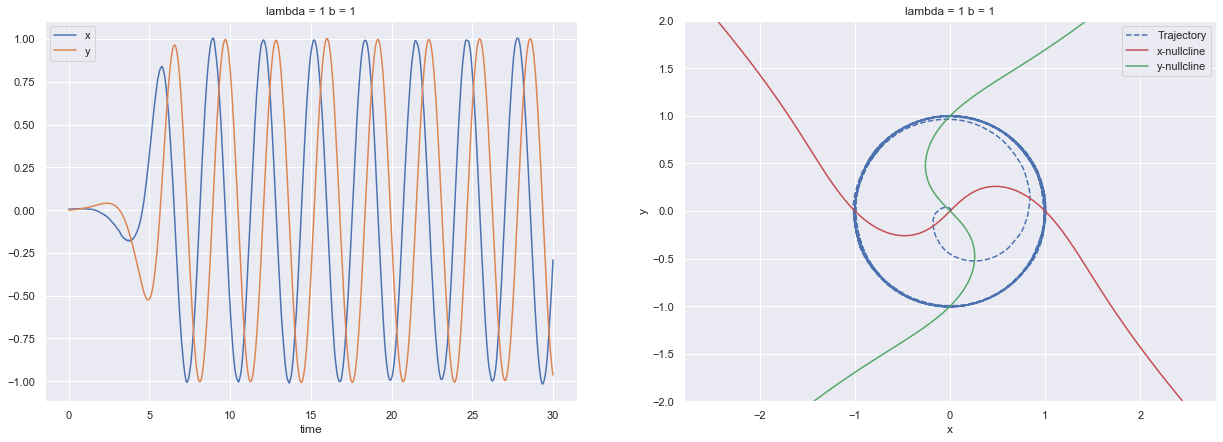

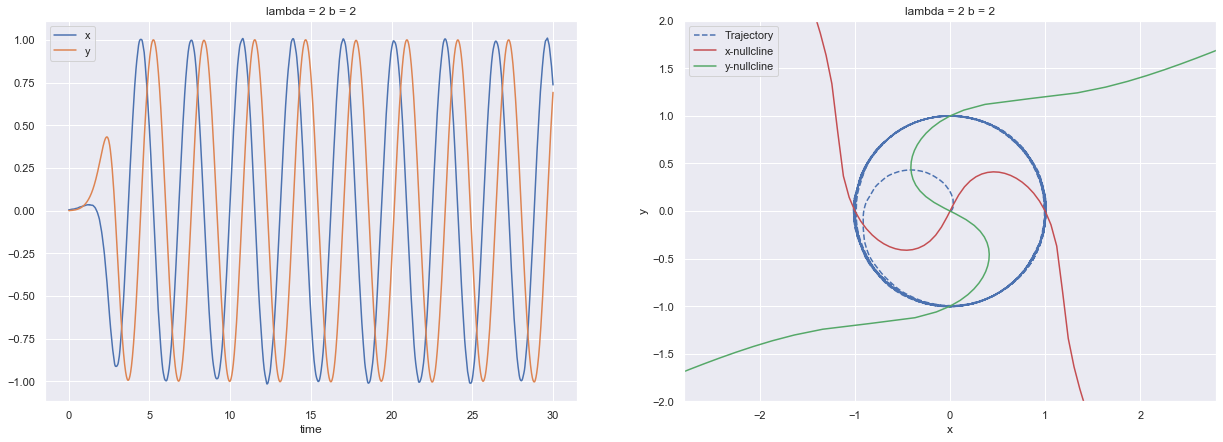

In [4]:
for i in [0.25, 1, 2]:
    #initialize a system (l, o, a, b, D = 0)
    lambda_omega = LambdaOmega2(i, 1, 1, i, 0.1)

    ## Integrates the system (r_0, theta_0, tini, tfin, nsteps)
    #t, dx_dt, dy_dt, x_t, y_t = lambda_omega.ode_solve(0.005, 0, 0, 30, 1000)

    # Integrates the system (r_0, theta_0, tini, tfin, timestep)
    t, dx_dt, dy_dt, x_t, y_t = lambda_omega.ode_solve(0.005, 0, 0, 30, 0.01)

    # Calculates the nullclines up to extend
    vals, x_nullcline, y_nullcline = lambda_omega.nullclines(extend = 3)

    fig = plt.figure(figsize=(21,7))
    
    #Trajectory
    plt.subplot(1,2,1)
    plt.title('lambda = ' + str(i) + ' b = ' + str(i))
    plt.plot(t, x_t, label = 'x')
    plt.plot(t, y_t, label = 'y')
    plt.xlabel('time')
    plt.legend();

    #Nullclines
    plt.subplot(1,2,2)
    plt.title('lambda = ' + str(i) + ' b = ' + str(i))    
    plt.plot(x_t, y_t, 'b--', label = 'Trajectory')
    plt.plot(vals,x_nullcline, 'r', label = 'x-nullcline')
    plt.plot(y_nullcline, vals, 'g', label = 'y-nullcline');
    plt.axis('equal')
    plt.xlim(-2, 2)
    plt.ylim(-2, 2)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend();

## Comparing system with and without noise on the phase diagram

In the following example, we create a system (Target) and generates 100 "noisy" samples of the same system to compare the evolution of the systems.

In [5]:
#TARGET

l = 0.25
o = 1
a = 1
b = 0.25
D = 0.1 #WHITE NOISE

#initialize a system (l, o, a, b, D = 0)
lambda_omega_target = LambdaOmega2(l, o, a, b, 0)

# Integrates the system (r_0, theta_0, tini, tfin, tstep)
lambda_omega_target.ode_solve(1, 0, 0, 30, 0.01);

noise = []
for _ in tqdm.tqdm(range(100)):
    #NOISE
    #initialize a system (l, o, a, b, D = 0.01)
    lambda_omega_noise = LambdaOmega2(l, o, a, b, D)
    # Integrates the system (r_0, theta_0, tini, tfin, tstep)
    lambda_omega_noise.ode_solve(0.005, 0, 0, 30, 0.01);
    noise.append(lambda_omega_noise)


100%|██████████| 100/100 [02:26<00:00,  1.46s/it]


The plots show the trajectories in the phase diagram (x, y)

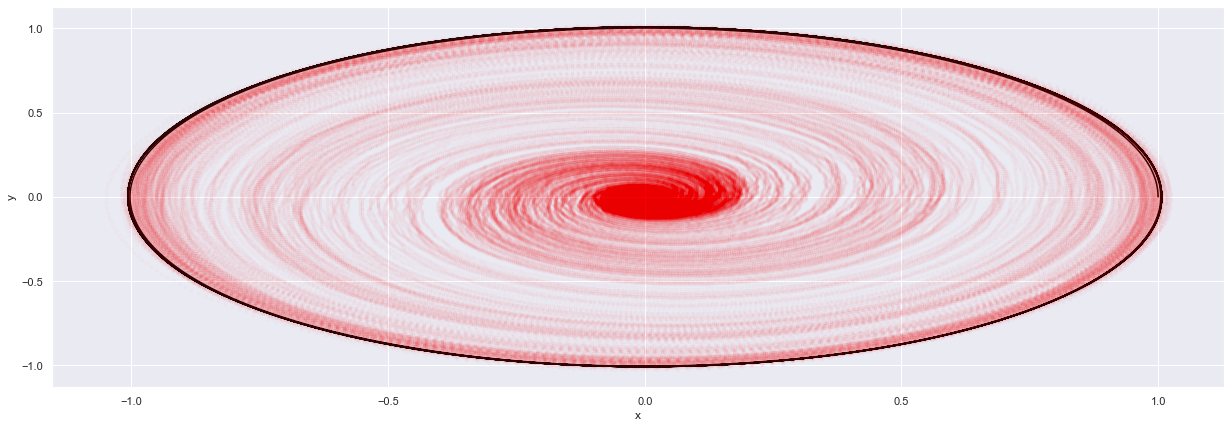

In [6]:
fig, ax = plt.subplots()
fig.set_size_inches(21,7)
ax.plot(lambda_omega_target.x_t, lambda_omega_target.y_t, color = 'k')

for i in noise:
    ax.plot(i.x_t, i.y_t,'.', color = 'red', alpha  = 0.01)

ax.set_xlabel('x')
ax.set_ylabel('y')
plt.show()


In [7]:
def digitize(trajectory, bins):
    x = trajectory.x_t
    y = trajectory.y_t
    counts, xedges, yedges = np.histogram2d(x, y, bins = bins)
    return counts/len(x)

def error(target_counts, noise_counts):
    return np.sqrt(sum(sum((target_counts - noise_counts)**2)))

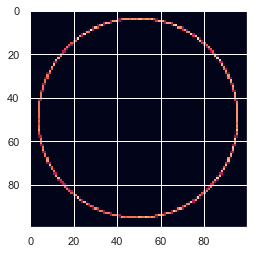

In [8]:
bins = np.linspace(-1.1,1.1,101)
target_counts = digitize(lambda_omega_target, [bins, bins])
plt.imshow(target_counts)

In [9]:
E = []
for i in noise:
    noise_counts = digitize(i, [bins, bins])
    E.append(error(target_counts, noise_counts))

print(np.mean(E))
print(np.min(E))
print(np.max(E))

0.1332872270682874
0.10465180361560905
0.216135245724626


# Automatization of the curve generation 

In [10]:
Ds = [0.001, 0.01, 0.1]
lambda_b = np.arange(0.25, 5.25, 0.25)
res = {'l_b':[], 'D': [], 'E_mean': [], 'E_max': [], 'E_min': []}

bins = np.linspace(-1.5,1.5,101)

#Create the target model without noise
theta = np.linspace(0, 360, int(30/0.01))
x = np.cos(theta)
y = np.sin(theta)
counts, _, _ = np.histogram2d(x, y, bins = bins)
target_counts = counts/len(x)

# loop over the lambda and b values
for l_b in tqdm.tqdm(lambda_b):
    
    #initialize a system (l, o, a, b, D = 0)
    #lambda_omega_target = LambdaOmega2(l_b, 1, 1, l_b, 0)
    
    # Integrates the system (r_0, theta_0, tini, tfin, nsteps)
    #lambda_omega_target.ode_solve(1, 0, 0, 30, 0.01);
    
    #Create the target model without noise
    #target_counts = digitize(lambda_omega_target, [bins, bins])
    
    #loop over the noise
    for D in Ds:
        
        noise = []
        
        #generate 100 equal models with noise
        for _ in range(100):
            
            #NOISE
            
            #initialize a system (l, o, a, b, D = 0.01)
            lambda_omega_noise = LambdaOmega2(l_b, 1, 1, l_b, D)
            
            # Integrates the system (r_0, theta_0, tini, tfin, timestep)
            lambda_omega_noise.ode_solve(0.005, 0, 0, 30, 0.01);
            noise.append(lambda_omega_noise)
            
        # calculate the statistics for each l_b and D
        E = []
        for i in noise:
            noise_counts = digitize(i, [bins, bins])
            E.append(error(target_counts, noise_counts))
            
        res['l_b'].append(l_b)
        res['D'].append(D)
        res['E_mean'].append(np.mean(E))
        res['E_min'].append(np.min(E))
        res['E_max'].append(np.max(E))        

100%|██████████| 20/20 [12:58<00:00, 38.93s/it]


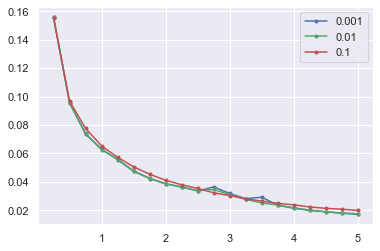

In [211]:
res = pd.DataFrame(res)

fig, ax = plt.subplots()
ax.plot(res[res['D'] == 0.001]['l_b'], res[res['D'] == 0.001]['E_mean'], 'b.', linestyle = '-', label = 'D = 0.001')
#ax.plot(res[res['D'] == 0.001]['l_b'], res[res['D'] == 0.001]['E_min'], 'b.', linestyle = '--')
#ax.plot(res[res['D'] == 0.001]['l_b'], res[res['D'] == 0.001]['E_max'], 'b.', linestyle = '--');

ax.plot(res[res['D'] == 0.01]['l_b'], res[res['D'] == 0.01]['E_mean'], 'g.', linestyle = '-', label = 'D = 0.01')
#ax.plot(res[res['D'] == 0.01]['l_b'], res[res['D'] == 0.01]['E_min'], 'g.', linestyle = '--')
#ax.plot(res[res['D'] == 0.01]['l_b'], res[res['D'] == 0.01]['E_max'], 'g.', linestyle = '--')

ax.plot(res[res['D'] == 0.1]['l_b'], res[res['D'] == 0.1]['E_mean'], 'r.', linestyle = '-', label = 'D = 0.1')
#ax.plot(res[res['D'] == 0.1]['l_b'], res[res['D'] == 0.1]['E_min'], 'r.', linestyle = '--')
#ax.plot(res[res['D'] == 0.1]['l_b'], res[res['D'] == 0.1]['E_max'], 'r.', linestyle = '--')

ax.legend()

# Analyzing the effect of the binning to measure the error








  0%|          | 0/6 [00:00<?, ?it/s]






 17%|█▋        | 1/6 [00:13<01:07, 13.47s/it]






 33%|███▎      | 2/6 [00:26<00:53, 13.38s/it]






 50%|█████     | 3/6 [00:39<00:40, 13.37s/it]






 67%|██████▋   | 4/6 [00:53<00:26, 13.33s/it]






 83%|████████▎ | 5/6 [01:07<00:13, 13.58s/it]






100%|██████████| 6/6 [02:16<00:00, 22.83s/it]


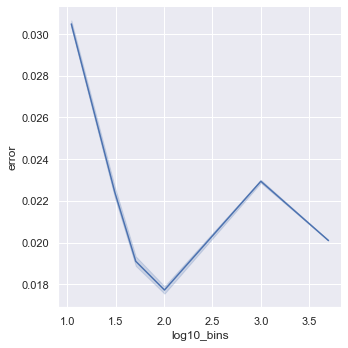

In [273]:
#fig, ax = plt.subplots()
er = []
n_bins = [11, 31, 51, 101, 1001, 5001]

#Create the target model without noise
theta = np.linspace(0, 360, int(30/0.001))
x = np.cos(theta)
y = np.sin(theta)

for n_bin in tqdm.tqdm(n_bins):
    bins = np.linspace(-1.1,1.1, n_bin)

    # TARGET
    counts, _, _ = np.histogram2d(x, y, bins = bins)
    target_counts = counts/len(x)

    
    #Noisy model
    np.random.seed(42)
    D = 0.1
    #initialize a system (l, o, a, b, D = 0.01)
    lambda_omega_noise = LambdaOmega2(l_b, 1, 1, l_b, D)

    for _ in range(100):
        # Integrates the system (r_0, theta_0, tini, tfin, timestep)
        lambda_omega_noise.ode_solve(0.005, 0, 0, 30, 0.01);

        noise_counts = digitize(lambda_omega_noise, [bins, bins])

        er.append([n_bin, np.sqrt(sum(sum((target_counts - noise_counts)**2)))])
        
er_df = pd.DataFrame(er, columns=['n_bins', 'error'])
er_df['log10_bins'] = np.log10(er_df.n_bins)
sns.relplot(kind = 'line', data = er_df, x = 'log10_bins', y = 'error')

# Analyzing the dynamics of the transient phase

### Changing $\lambda$ and b fixing initial conditions

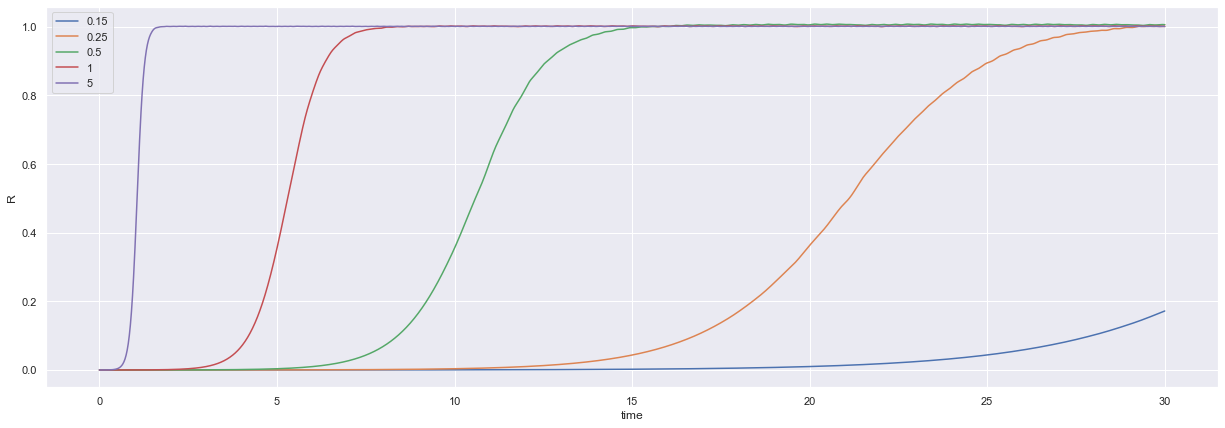

In [27]:
fig, ax = plt.subplots(figsize=(21,7))

for i in [0.15, 0.25, 0.5, 1, 5]:
    #initialize a system (l, o, a, b, D = 0)
    lambda_omega = LambdaOmega2(i, 1, 1, i, 0)

    # Integrates the system (r_0, theta_0, tini, tfin, timestep)
    t, dx_dt, dy_dt, x_t, y_t = lambda_omega.ode_solve(0.005, 0, 0, 30, 0.01)


    #Trajectory
    ax.plot(t, x_t**2 + y_t**2, label = i)
    ax.set(xlabel = 'time', ylabel = 'R')
    ax.legend();

### Changing initial conditions fixing $\lambda$ and b

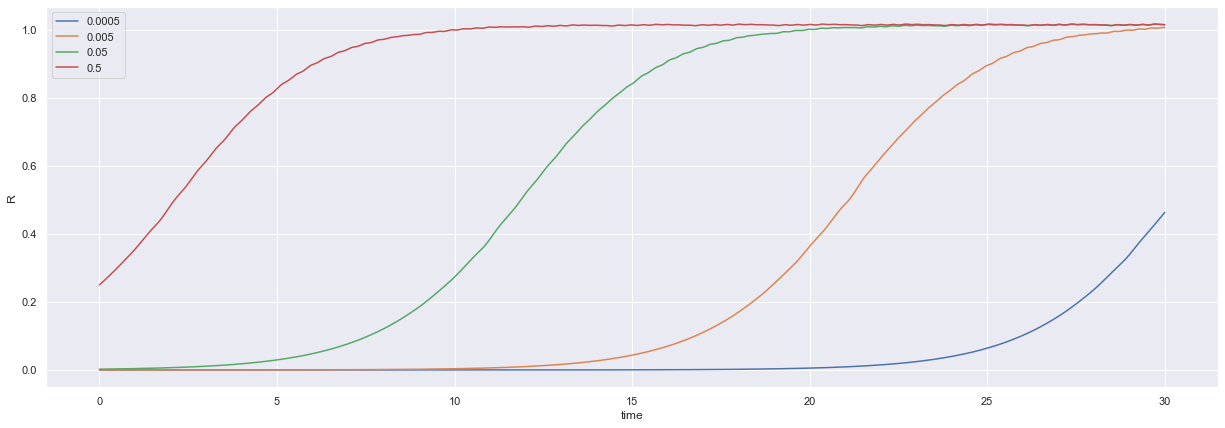

In [34]:
fig, ax = plt.subplots(figsize=(21,7))

for i in [0.0005, 0.005, 0.05, 0.5]:
    #initialize a system (l, o, a, b, D = 0)
    lambda_omega = LambdaOmega2(0.25, 1, 1, 0.25, 0)

    # Integrates the system (r_0, theta_0, tini, tfin, timestep)
    t, dx_dt, dy_dt, x_t, y_t = lambda_omega.ode_solve(i, 0, 0, 30, 0.01)


    #Trajectory
    ax.plot(t, x_t**2 + y_t**2, label = i)
    ax.set(xlabel = 'time', ylabel = 'R')
    ax.legend();

### Determining lifetime of the transient by curve_fitting

In [35]:
from scipy.optimize import curve_fit

In [36]:
#def sigmoid(x, L , x0, k, b):
#    y = L / (1 + np.exp(-k*(x-x0)))+b
#    return (y)

def sigmoid(x, x0, k):
    return 1 / (1 + np.exp(-k*(x-x0)))

In [98]:
#initialize a system (l, o, a, b, D = 0)
lambda_omega = LambdaOmega2(0.25, 1, 1, 0.25, 0)

# Integrates the system (r_0, theta_0, tini, tfin, timestep)
t, dx_dt, dy_dt, x_t, y_t = lambda_omega.ode_solve(0.005, 0, 0, 30, 0.01)

In [99]:
xdata = t
ydata = x_t**2 + y_t**2

def fit_r(x_data, y_data):
    p0 = [np.median(xdata),1] # this is an mandatory initial guess
    popt, _ = curve_fit(sigmoid, xdata, ydata, p0, method='dogbox')
    return popt

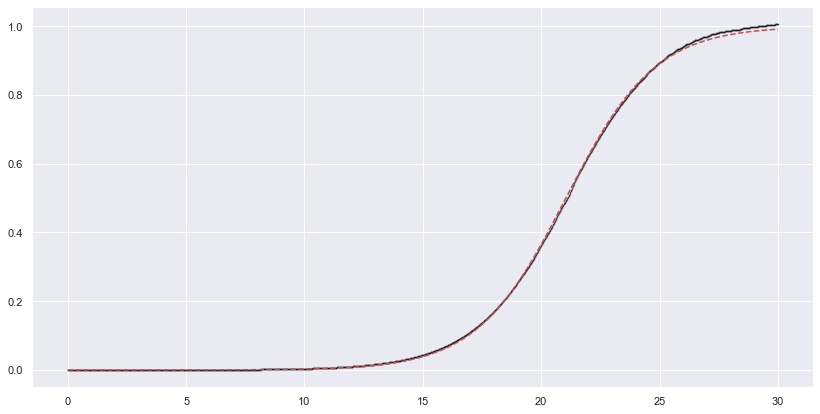

In [100]:
fig, ax = plt.subplots(figsize=(14,7))
popt = fit_r(xdata, ydata)
plt.plot(xdata, ydata, 'k.', alpha = 0.5, markersize = 1)
plt.plot(xdata, sigmoid(xdata, *popt), 'r', linestyle = '--');

## Estimating $\lambda$ and b from k

In [115]:
lambdas = np.array([0.01, 0.1, 0.25, 0.5, 1, 2, 3, 4, 5, 7.5, 10])
ks = []
for i in lambdas:
    lambda_omega = LambdaOmega2(i, 1, 1, i, 0)
    t, dx_dt, dy_dt, x_t, y_t = lambda_omega.ode_solve(0.005, 0, 0, 30, 0.01)
    
    xdata = t
    ydata = x_t**2 + y_t**2
    popt = fit_r(xdata, ydata)
    #print(i, popt[0], popt[1])
    ks.append(popt[1])
ks = np.array(ks)

In [121]:
import statsmodels.api as sm

In [124]:
ks_1 = sm.add_constant(ks)
mod = sm.OLS(lambdas, ks_1)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.599e+06
Date:                Fri, 22 May 2020   Prob (F-statistic):           6.16e-25
Time:                        16:46:16   Log-Likelihood:                 38.191
No. Observations:                  11   AIC:                            -72.38
Df Residuals:                       9   BIC:                            -71.59
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0095      0.003     -2.728      0.0

/Users/dbikiel/opt/anaconda3/envs/test/lib/python3.7/site-packages/scipy/stats/stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  "anyway, n=%i" % int(n))


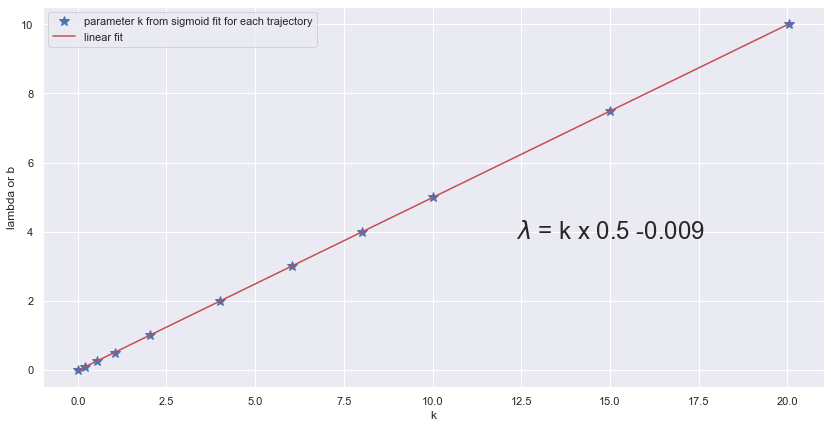

In [130]:
fig, ax = plt.subplots(figsize=(14,7))
ax.plot(ks, lambdas, '*', markersize = 10, label = 'parameter k from sigmoid fit for each trajectory');

ax.plot(ks, res.params[1]*ks + res.params[0], 'r', linestyle = '-', label = 'linear fit');

ax.set(xlabel = 'k', ylabel = 'lambda or b')
ax.text(15, 4, '$\lambda$ = k x ' + str(np.round(res.params[1],3)) + ' ' +  str(np.round(res.params[0],3)), size=24, ha='center', va='center')
ax.legend();